Structure similarity investigation of GDB-13 fragrance-like molecules database 

In [19]:
import rdkit
import pandas as pd
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
import rdkit.DataStructs
from rdkit.DataStructs.cDataStructs import ExplicitBitVect
from e3fp.pipeline import fprints_from_smiles
import numpy as np

# similarity
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity, DiceSimilarity
#from e3fp.fingerprint.metrics.array_metrics import tanimoto, soergel
from e3fp.fingerprint.metrics.fprint_metrics import tanimoto, soergel

# drawing
from rdkit.Chem import Draw 
from rdkit.Chem.Draw import SimilarityMaps


In [ ]:
# convert SMI to csv - use pandas to convert text file to dataframe 
column_name=["Smiles"]
df = pd.read_csv('/home/martyn0000/fragrance_investigation/GDB-13-FL.smi',
                sep='\r\n', engine='python', names=column_name
                )
df = df.iloc[1: , :]
print(df.head(2))

# smaller subset of dataframe (1M entries) used to test other functions
#df1 = df.iloc[:1000000,:]
#print(df1.head(2))

In [ ]:
# try filtering on full dataset to see how much it can be reduced by - remove S, N, Cl reduces only from 59M to 58M. Try to find only the molecules containing oxygen - 53M, 815 MB of text. Restrict length to 8 and more atoms - 10M 

#make a copy of main dataframe
df_sanitised = df.copy()
#loop through, remove S
regex_expression1 = "[Ss]"
filter1 = df_sanitised['Smiles'].str.contains(regex_expression1)
df_sanitised=df_sanitised[~filter1]
# remove N 
regex_expression2 = "[Nn]"
filter2 = df_sanitised['Smiles'].str.contains(regex_expression2)
df_sanitised=df_sanitised[~filter2]
# remove Cl 
regex_expression3 = "(Cl)"
filter3 = df_sanitised['Smiles'].str.contains(regex_expression3)
df_sanitised=df_sanitised[~filter3]
#keep only O 
regex_expression4 = "[Oo]"
filter4 = df_sanitised['Smiles'].str.contains(regex_expression4)
df_sanitisedO = df_sanitised[filter4]

# length filter
regex_expression5 = "(\\s*[A-Z]\\W*\\s*){8}"
filter5 = df_sanitisedO['Smiles'].str.contains(regex_expression5)
df_shortened = df_sanitisedO[filter5]
#df_shortened = df_sanitisedO.loc[(df_sanitised['Smiles'].str.len() == 8)] doesn't work because special characters in SMILES are counted 
print(len(df_shortened.index))
print(df_shortened.head(5))


In [3]:
# split len8 dataframe in five 
df_shortened = pd.read_csv('/home/martyn0000/fragrance_investigation/df8_just_Smiles.csv')

df8_1 = df_shortened.iloc[:2000000, :]
print(df8_1.head(2))
print(len(df8_1.index))

df8_2 = df_shortened.iloc[2000000:4000000, :]
print(df8_2.head(2))
print(len(df8_2.index))

df8_3 = df_shortened.iloc[4000000:6000000, :]
print(df8_3.head(2))
print(len(df8_3.index))

df8_4 = df_shortened.iloc[6000000:8000000, :]
print(df8_4.head(2))
print(len(df8_4.index))

df8_5 = df_shortened.iloc[8000000:, :]
print(df8_5.head(2))
print(len(df8_5.index))

   Unnamed: 0            Smiles
0        1027     OC[CH-]C#CC=O
1        1030  O=C[CH-]C(=O)C#C
2000000
         Unnamed: 0           Smiles
2000000    14914198   CC(C)=CCC#CC=O
2000001    14914199  CC(C)=CCCC(C)=O
2000000
         Unnamed: 0                   Smiles
4000000    34054809  CC1=CC=CC(C)=C(COC=O)C1
4000001    34054810  CC1=CC=CC(C)=CC(=O)COC1
2000000
         Unnamed: 0                  Smiles
6000000    45321238   CCCCC1C=CC(C)(CO)C=C1
6000001    45321239  CCCCC1C=CC(C)C(=O)C=C1
2000000
         Unnamed: 0                   Smiles
8000000    49220390  CCC(=O)C1=C(C)CCOC(C)C1
8000001    49220391   CCC(=O)C1=C(C)CCOCC=C1
2102473


In [4]:
# try molecule object and fingerprints separately - takes approx 15 minutes to generate 2M mol objects

df8_1_mols = df8_1.copy()
PandasTools.AddMoleculeColumnToFrame(df8_1_mols,'Smiles','molecule',includeFingerprints=True)


In [5]:
# rdkit calculate features - Morgan fingerprint (slow)
# and store the bitvects as base64-encoded strings

# Generate Morgan fingerprints from mol object 
df8_1_mols['morgan'] = df8_1_mols['molecule'].map(lambda x: GetMorganFingerprintAsBitVect(x,2)) 
#print(df8_1_mols.head(2))

# number of bits in the bitvect (need this when reading CSV back)
bit_vect_len = (df8_1_mols['morgan'].map(lambda x: x.GetNumBits()))[0]

# convert bitvects to base64-encoded string for CSV/plaintext storage
df8_1_mols['morgan64'] = df8_1_mols['morgan'].map(lambda bv: bv.ToBase64())

# throw away stuff we don't want to store (raw mol and bitvect objects)
df8_1_for_storage = df8_1_mols.drop('molecule', axis=1).drop('morgan', axis=1)

#print(df8_1_for_storage.head(2))
df8_1_for_storage.to_csv('df8_1_with_Morgan_fingerprints.csv', index=False)
# write to the concatenated CSV file
# `mode='w'` means "write", OVERWRITING the existing file (df8_2 through 5 will need rewriting after this)
# we DO want a header, since this is the first write / first df we write
df8_1_for_storage.to_csv('df8_concat_with_Morgan_fingerprints.csv', mode='w', index=False, header=True)
print("DONE: df8_1_for_storage written")


DONE: df8_1_for_storage written


In [6]:
df8_2_mols = df8_2.copy()
PandasTools.AddMoleculeColumnToFrame(df8_2_mols,'Smiles','molecule',includeFingerprints=True)

In [7]:
# Generate Morgan fingerprints from mol object 
df8_2_mols['morgan'] = df8_2_mols['molecule'].map(lambda x: GetMorganFingerprintAsBitVect(x,2)) 
#print(df8_2_mols.head(2))

# convert bitvects to base64-encoded string for CSV/plaintext storage
df8_2_mols['morgan64'] = df8_2_mols['morgan'].map(lambda bv: bv.ToBase64())

# throw away stuff we don't want to store (raw mol and bitvect objects)
df8_2_for_storage = df8_2_mols.drop('molecule', axis=1).drop('morgan', axis=1)

#print(df8_2_for_storage.head(2))
df8_2_for_storage.to_csv('df8_2_with_Morgan_fingerprints.csv', index=False)
# write to the concatenated CSV file
# `mode='a'` means "append"
# we DON'T want a header (it's written by df8_1)
df8_2_for_storage.to_csv('df8_concat_with_Morgan_fingerprints.csv', mode='a', index=False, header=False)
print("DONE: df8_2_for_storage written")

DONE: df8_2_for_storage written


In [3]:
df8_3_mols = df8_3.copy()
PandasTools.AddMoleculeColumnToFrame(df8_3_mols,'Smiles','molecule',includeFingerprints=True)

In [4]:
# Generate Morgan fingerprints from mol object 
df8_3_mols['morgan'] = df8_3_mols['molecule'].map(lambda x: GetMorganFingerprintAsBitVect(x,2)) 
#print(df8_3_mols.head(2))

# convert bitvects to base64-encoded string for CSV/plaintext storage
df8_3_mols['morgan64'] = df8_3_mols['morgan'].map(lambda bv: bv.ToBase64())

# throw away stuff we don't want to store (raw mol and bitvect objects)
df8_3_for_storage = df8_3_mols.drop('molecule', axis=1).drop('morgan', axis=1)

#print(df8_3_for_storage.head(2))
df8_3_for_storage.to_csv('df8_3_with_Morgan_fingerprints.csv', index=False)
# write to the concatenated CSV file
# `mode='a'` means "append"
# we DON'T want a header (it's written by df8_1)
df8_3_for_storage.to_csv('df8_concat_with_Morgan_fingerprints.csv', mode='a', index=False, header=False)
print("DONE: df8_3_for_storage written")

DONE: df8_3_for_storage written


In [5]:
df8_4_mols = df8_4.copy()
PandasTools.AddMoleculeColumnToFrame(df8_4_mols,'Smiles','molecule',includeFingerprints=True)

In [6]:
# Generate Morgan fingerprints from mol object 
df8_4_mols['morgan'] = df8_4_mols['molecule'].map(lambda x: GetMorganFingerprintAsBitVect(x,2)) 
#print(df8_4_mols.head(2))

# convert bitvects to base64-encoded string for CSV/plaintext storage
df8_4_mols['morgan64'] = df8_4_mols['morgan'].map(lambda bv: bv.ToBase64())

# throw away stuff we don't want to store (raw mol and bitvect objects)
df8_4_for_storage = df8_4_mols.drop('molecule', axis=1).drop('morgan', axis=1)

#print(df8_4_for_storage.head(2))
df8_4_for_storage.to_csv('df8_4_with_Morgan_fingerprints.csv', index=False)
# write to the concatenated CSV file
# `mode='a'` means "append"
# we DON'T want a header (it's written by df8_1)
df8_4_for_storage.to_csv('df8_concat_with_Morgan_fingerprints.csv', mode='a', index=False, header=False)
print("DONE: df8_4_for_storage written")

DONE: df8_4_for_storage written


In [4]:
df8_5_mols = df8_5.copy()
PandasTools.AddMoleculeColumnToFrame(df8_5_mols,'Smiles','molecule',includeFingerprints=True)

In [5]:
# Generate Morgan fingerprints from mol object 
df8_5_mols['morgan'] = df8_5_mols['molecule'].map(lambda x: GetMorganFingerprintAsBitVect(x,2)) 
#print(df8_5_mols.head(2))

# convert bitvects to base64-encoded string for CSV/plaintext storage
df8_5_mols['morgan64'] = df8_5_mols['morgan'].map(lambda bv: bv.ToBase64())

# throw away stuff we don't want to store (raw mol and bitvect objects)
df8_5_for_storage = df8_5_mols.drop('molecule', axis=1).drop('morgan', axis=1)

#print(df8_5_for_storage.head(2))
df8_5_for_storage.to_csv('df8_5_with_Morgan_fingerprints.csv', index=False)
# write to the concatenated CSV file
# `mode='a'` means "append"
# we DON'T want a header (it's written by df8_1)
df8_5_for_storage.to_csv('df8_concat_with_Morgan_fingerprints.csv', mode='a', index=False, header=False)
print("DONE: df8_5_for_storage written")

DONE: df8_5_for_storage written


In [ ]:
# concatenate dataframes with fingerprints - absolutely not happening, can only run one or two 2M dataframes before VSCode dies 
#frames = [df8_1_mols, df8_2_mols, df8_3_mols, df8_4_mols, df8_5_mols]
#df8 = pd.concat(frames)

# remove molecule column, store as .csv 
#df8_morgan_for_storage = df8.drop('molecule', axis=1)
#df8_morgan_for_storage.to_csv('df8_with_Morgan_fingerprints.csv')

In [14]:
# convert the given base64-encoded string form of a bitvect back into a bitvect
def bit_vect_from_string(base64_string: str):
    # create an empty bitvect
    emptyBitVect = ExplicitBitVect(int(bit_vect_len))
    # update the bitvect to the value in the base64-encoded string
    emptyBitVect.FromBase64(base64_string)
    # return the updated bitvect (which now contains the right value!)
    return emptyBitVect

In [17]:
df8_Morgan = pd.read_csv('/home/martyn0000/fragrance_investigation/df8_concat_with_Morgan_fingerprints.csv')
# TODO: update path to concatenated CSV
#       'df8_concat_with_Morgan_fingerprints.csv'
df8_Morgan['morgan'] = df8_Morgan['morgan64'].map(lambda s: bit_vect_from_string(s))

# similarity search of database (actually quite fast)

# specify target molecule as SMILES 
similarity_target=Chem.MolFromSmiles("C[C@@]1(C(C)=O)CC=C2CCCC(C)(C)[C@]2(C)[C@H]1C") 

def get_dataframe_with_x_most_similar_compounds_to_query(query, mol_df, molCol='molecule', x=int):
    query_fp = GetMorganFingerprintAsBitVect(query,2)
    mol_df['similarity'] = mol_df['morgan'].map(lambda x: TanimotoSimilarity(query_fp, x))
    mol_df.sort_values(['similarity'], ascending=False, inplace=True)
    return mol_df[:x].copy()  

similarity_df = get_dataframe_with_x_most_similar_compounds_to_query(similarity_target, df8_Morgan, x=1000000)
PandasTools.RenderImagesInAllDataFrames()
similarity_df.head(10)


,Unnamed: 0,Smiles,morgan64,morgan,similarity
4122879,34252910,CC(=O)C1(C)CC=C(C)CCC1O,4P///wAIAAAdAAAAbgpZBHD42lw2NhBqtAJKBBEBIGRszo...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.400000
4487817,35494117,CC(=O)C1(C)CCCC(C)=CC1O,4P///wAIAAAdAAAAbp0AYK0AmAEAcQDcDrQCEDgECr68IN...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.400000
2247845,17753640,CC(=O)C1(C)CCCC(C)=CC1,4P///wAIAAAbAAAAevkDzQAycQCAamxGFDgEyt7SxAQCtQ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.386364
8343235,50324213,CC(=O)C1(C)CC=C(C)C(=O)C1O,4P///wAIAAAcAAAAbgpZAUpIxQAC7DYBAOwqiAJKBBEBIN...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.377778
1560787,11578325,CC(=O)C1(C)CCCC(=O)CC1O,4P///wAIAAAcAAAAAGydAAIKIoAFAD5k9HxcXOy0AhA4BM...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.377778
8317703,50297149,CC(=O)C1(C)CC=C(C)C(=C)C1O,4P///wAIAAAdAAAARiYKlQD2xQDwcQBCqLQCSgQRASC2Gs...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.369565
8317824,50297270,CC(=O)C1(C)CCCC(=C)CC1O,4P///wAIAAAdAAAAAEQeBp0ADlEBNQF8XFzstAIQOATKvC...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.369565
8317701,50297147,CC(=O)C1(C)CC=C(C)C=CC1O,4P///wAIAAAdAAAAbgqlAG4NAsyUouy0AkoECiAxAEAg0s...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.369565
8317821,50297267,CC(=O)C1(C)CCCC=C(C)C1O,4P///wAIAAAdAAAAbrYuZqkEYQAG7LQCEDgEFpQcvCDSzl...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.369565
4350375,34873554,CC(=O)C1(C)CCC(C)=CCC1O,4P///wAIAAAdAAAAAGwWNQWIZtpcPEIuOrQCSgTKvCDSzo...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.369565


In [22]:
# output similarity_df as a SMILES-only .csv for further processing
similarity_df_for_storage = similarity_df.drop('morgan64', axis=1).drop('morgan', axis=1).drop('similarity', axis=1)
similarity_df_for_storage.head(10)
similarity_df_for_storage.to_csv('similarity_1M.csv')

In [42]:
# now we have a dataframe of similar molecules by Morgan fingerprint - try a 3D structure similarity search. Shape-based? Try e3fp or ESPsim (shape and electrostatics)
df_filtered = pd.read_csv('/home/martyn0000/fragrance_investigation/similarity_1M.csv')
df_filtered = df_filtered.head(100)

#just need to create a column called 'name' for the fingerprint function to work 
df_filtered.rename(columns={ df_filtered.columns[0]: "name" }, inplace=True)
# get SMILES from similarity_df, create fingerprint column, generate fingerprints and put in dataframe 

# TODO: conformer_params? fingerprint_params? format: "<key>": <value>
# see: https://e3fp.readthedocs.io/en/latest/usage/config.html
# conformer_params = {
#     "max_energy_diff": 20,
#     "first": -1
#     }
# df_filtered['fingerprints'] = df_filtered.apply(lambda x: fprints_from_smiles(x.Smiles, str(x.name), confgen_params=conformer_params), axis=1)
#
# CAUTION: the line below removes the default limit of only generating the first 3 fingerprints
#          (similar style to conformer parameters)
# fingerprint_params = {
#    "first": -1
#    }
# df_filtered['fingerprints'] = df_filtered.apply(
#    lambda x: fprints_from_smiles(x.Smiles, str(x.name), fprint_params=fingerprint_params),
#    axis=1
#    )


df_filtered['fingerprints'] = df_filtered.apply(lambda x: fprints_from_smiles(x.Smiles, str(x.name)), axis=1)

nrows_pre_explosion = df_filtered.shape[0]
# `fprints_from_smiles` returns a list of fingerprints
# `explode` expands the list into a separate entry for each fingerprint
df_filtered = df_filtered.explode('fingerprints')

nrows_post_explosion = df_filtered.shape[0]
print(f"Calling `explode` created {nrows_post_explosion / nrows_pre_explosion}-times more entries!")

# print the first 2 entries, adjusted for explosion
print(df_filtered.head(2 * int(nrows_post_explosion/nrows_pre_explosion)))


2023-05-16 23:07:07,145|INFO|Generating conformers for 0.
2023-05-16 23:07:08,388|INFO|Generated 30 conformers for 0.
2023-05-16 23:07:08,389|INFO|Generating fingerprints for 0.
2023-05-16 23:07:08,505|INFO|Generated 3 fingerprints for 0.
2023-05-16 23:07:08,506|INFO|Generating conformers for 1.
2023-05-16 23:07:09,720|INFO|Generated 27 conformers for 1.
2023-05-16 23:07:09,721|INFO|Generating fingerprints for 1.
2023-05-16 23:07:09,875|INFO|Generated 3 fingerprints for 1.
2023-05-16 23:07:09,878|INFO|Generating conformers for 2.
2023-05-16 23:07:11,215|INFO|Generated 18 conformers for 2.
2023-05-16 23:07:11,217|INFO|Generating fingerprints for 2.
2023-05-16 23:07:11,368|INFO|Generated 3 fingerprints for 2.
2023-05-16 23:07:11,369|INFO|Generating conformers for 3.
2023-05-16 23:07:12,210|INFO|Generated 15 conformers for 3.
2023-05-16 23:07:12,211|INFO|Generating fingerprints for 3.
2023-05-16 23:07:12,336|INFO|Generated 3 fingerprints for 3.
2023-05-16 23:07:12,339|INFO|Generating conf

KeyboardInterrupt: 

In [34]:
#print(df_filtered['fingerprints'][0])
#query_fp_list = fprints_from_smiles(
#    'C[C@@]1(C(C)=O)CC=C2CCCC(C)(C)[C@]2(C)[C@H]1C',
#    'query',
#    fprint_params={"first": -1}
#    )
#first_fp_list = fprints_from_smiles('CC(=O)C1(C)CC=C(C)CCC1O', 'test')
#print(query_fp_list)
#[[tanimoto(qfp, ffp) for ffp in first_fp_list] for qfp in query_fp_list]

2023-05-16 22:40:23,106|INFO|Generating conformers for query.


0    (False, False, False, False, False, False, Fal...
0    (False, False, False, False, False, False, Fal...
0    (False, False, False, False, False, False, Fal...
Name: fingerprints, dtype: object


2023-05-16 22:40:27,278|INFO|Generated 10 conformers for query.
2023-05-16 22:40:27,279|INFO|Generating fingerprints for query.
2023-05-16 22:40:27,693|INFO|Generated 10 fingerprints for query.


[Fingerprint(indices=array([34585944, 54407153, 163353529, 471508139, 526356276, 563733172, 598921722, 710392643, 746246176, 796320448, 917049764, 1099509014, 1354262286, 1442600728, 1519150424, 1610406593, 1788716668, 1792786177, 2224113185, 2312766102, 2453405156, 2479911905, 2553892988, 2738552880, 2782322589, 3015580601, 3200307741, 3382076979, 3467312702, 3560653707, 3588120588, 3758538115, 4072641186, 4197996711, 4215406029]), level=5, bits=4294967296, name=query_0), Fingerprint(indices=array([54407153, 169908505, 471508139, 526356276, 560973635, 563733172, 598921722, 710392643, 746246176, 917049764, 1099509014, 1180748505, 1354262286, 1442600728, 1519150424, 1610406593, 1782754007, 1788716668, 1792786177, 2239715354, 2312766102, 2431698205, 2453405156, 2479911905, 2553892988, 2738552880, 2782322589, 3015580601, 3200307741, 3467312702, 3560653707, 3588120588, 4072641186, 4197996711, 4215406029]), level=5, bits=4294967296, name=query_1), Fingerprint(indices=array([61861563, 334204

In [13]:
df_filtered.to_csv('df_filtered_100_with_3D_fingerprints.csv')

In [41]:
similarity_target="C[C@@]1(C(C)=O)CC=C2CCCC(C)(C)[C@]2(C)[C@H]1C"

def get_dataframe_with_x_most_similar_3D_compounds_to_query(query, mol_df, x=int):
    query_3D_fp_list = fprints_from_smiles(query, "query")
    # CAUTION: the line below removes the default limit of only generating the first 3 fingerprints
    #query_3D_fp_list = fprints_from_smiles(query, "query", fprint_params={"first": -1})
    
    mol_df['3D_similarity'] = mol_df['fingerprints'].map(
        # as with the dataframe, the query contains multiple fingerprints so we compare with each...
        lambda fp: [tanimoto(query_fp, fp) for query_fp in query_3D_fp_list]
        )
    # ... and then we `explode` the lists into individual entries
    print("We are about to call `explode`.")
    print(f"This will create {len(query_3D_fp_list)}-times more entries!")
    mol_df = mol_df.explode('3D_similarity')

    # sanity-check that we actually have some values
    print(mol_df['3D_similarity'].head(9))

    mol_df.sort_values(['3D_similarity'], ascending=False, inplace=True)
    return mol_df[:x].copy()

similarity_3D_df = get_dataframe_with_x_most_similar_3D_compounds_to_query(similarity_target, df_filtered, x=10)
PandasTools.RenderImagesInAllDataFrames()
similarity_3D_df.head(5)

2023-05-16 22:55:11,320|INFO|Generating conformers for query.
2023-05-16 22:55:15,349|INFO|Generated 9 conformers for query.
2023-05-16 22:55:15,350|INFO|Generating fingerprints for query.
2023-05-16 22:55:15,486|INFO|Generated 3 fingerprints for query.


We are about to call `explode`.
This will create 3-times more entries!
900
0    0.306122
0    0.306122
0         0.3
0         0.3
0         0.3
0        0.32
0         0.3
0         0.3
0    0.294118
Name: 3D_similarity, dtype: object


,name,Unnamed: 0,Smiles,fingerprints,3D_similarity
2,2247845,17753640,CC(=O)C1(C)CCCC(C)=CC1,"(False, False, False, False, False, False, Fal...",0.355556
2,2247845,17753640,CC(=O)C1(C)CCCC(C)=CC1,"(False, False, False, False, False, False, Fal...",0.355556
2,2247845,17753640,CC(=O)C1(C)CCCC(C)=CC1,"(False, False, False, False, False, False, Fal...",0.355556
2,2247845,17753640,CC(=O)C1(C)CCCC(C)=CC1,"(False, False, False, False, False, False, Fal...",0.355556
2,2247845,17753640,CC(=O)C1(C)CCCC(C)=CC1,"(False, False, False, False, False, False, Fal...",0.355556


['CC(=O)C1(C)CC=C(C)CCC1O', 'CC(=O)C1(C)CCCC(C)=CC1O', 'CC(=O)C1(C)CCCC(C)=CC1', 'CC(=O)C1(C)CC=C(C)C(=O)C1O', 'CC(=O)C1(C)CCCC(=O)CC1O', 'CC(=O)C1(C)CC=C(C)C(=C)C1O', 'CC(=O)C1(C)CCCC(=C)CC1O', 'CC(=O)C1(C)CC=C(C)C=CC1O', 'CC(=O)C1(C)CCCC=C(C)C1O', 'CC(=O)C1(C)CCC(C)=CCC1O']


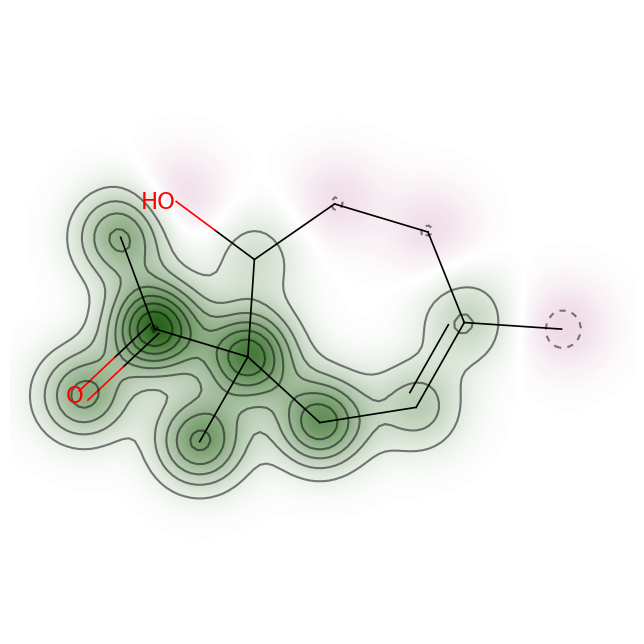

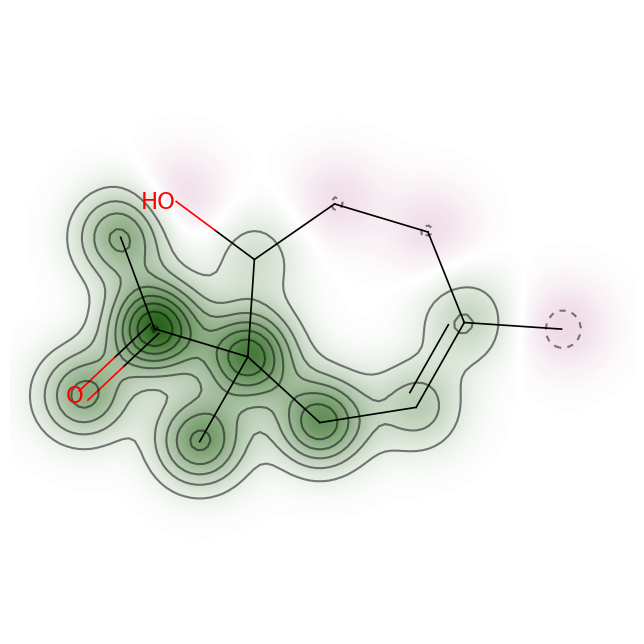

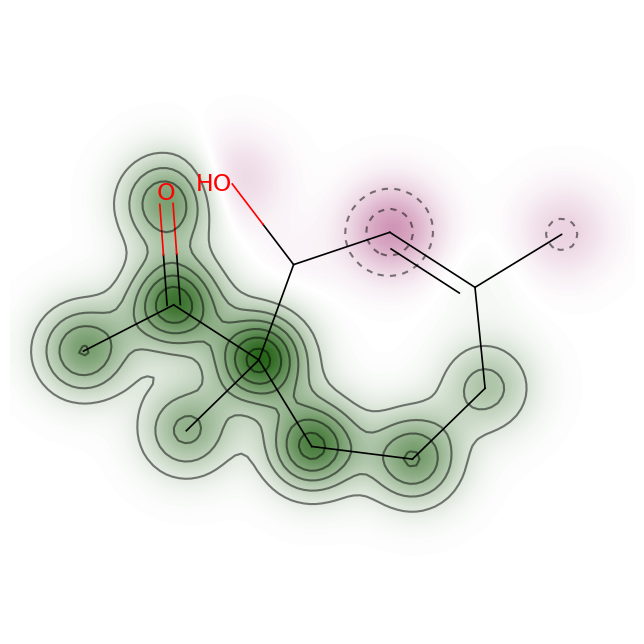

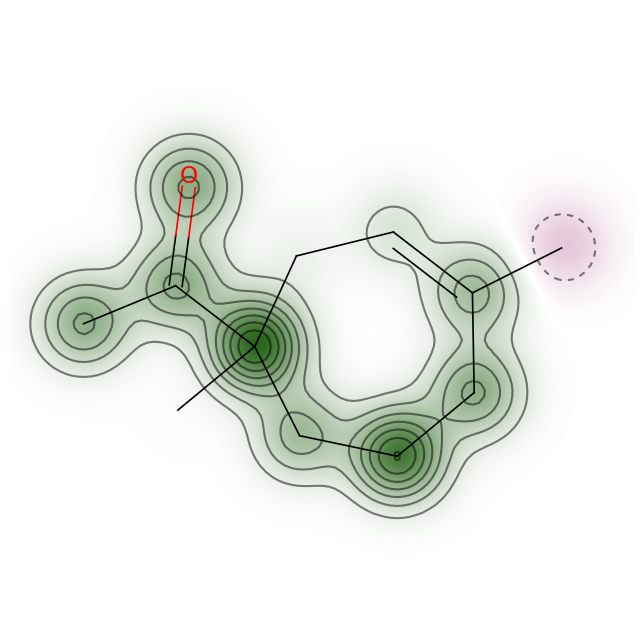

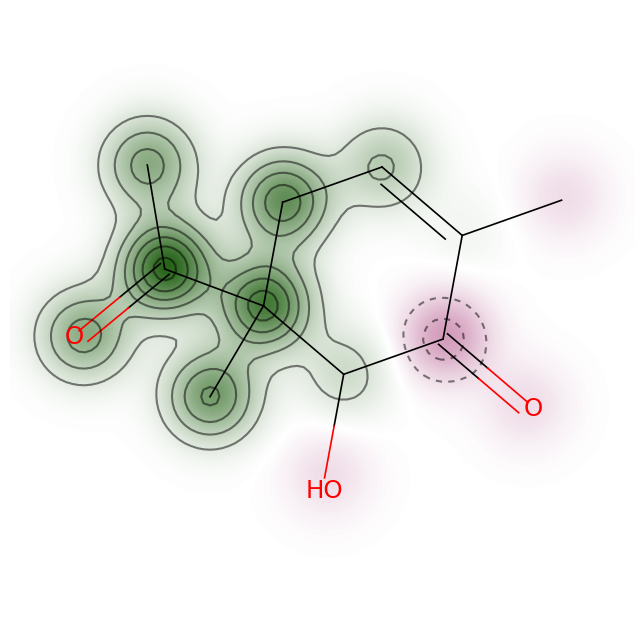

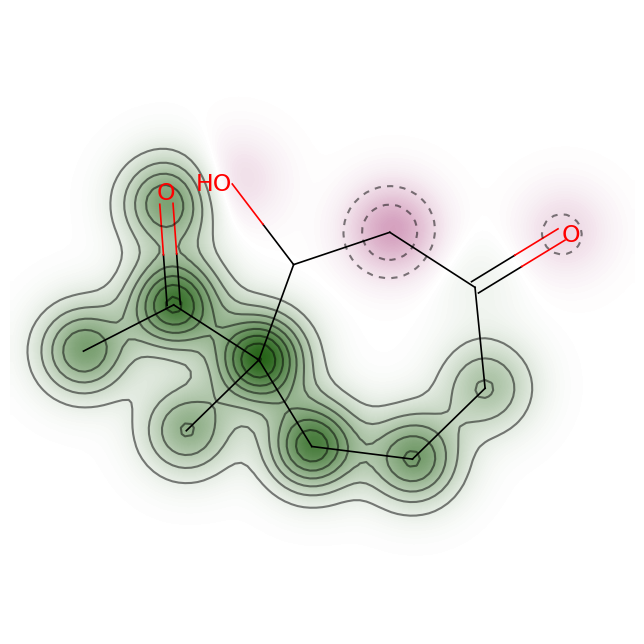

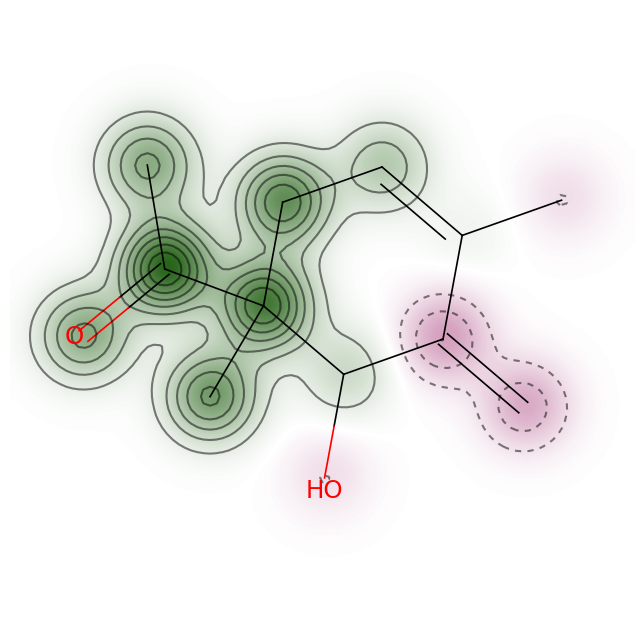

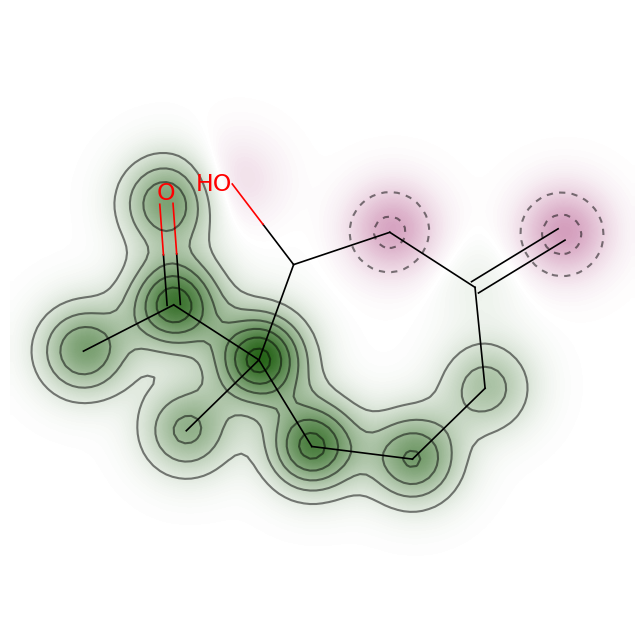

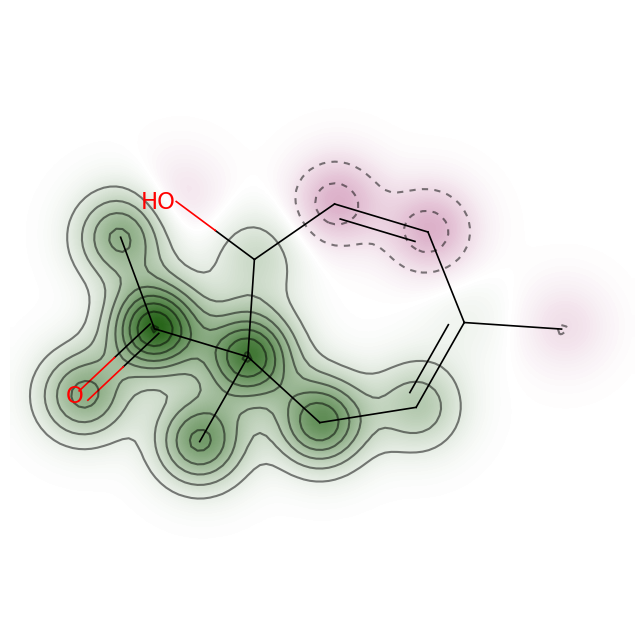

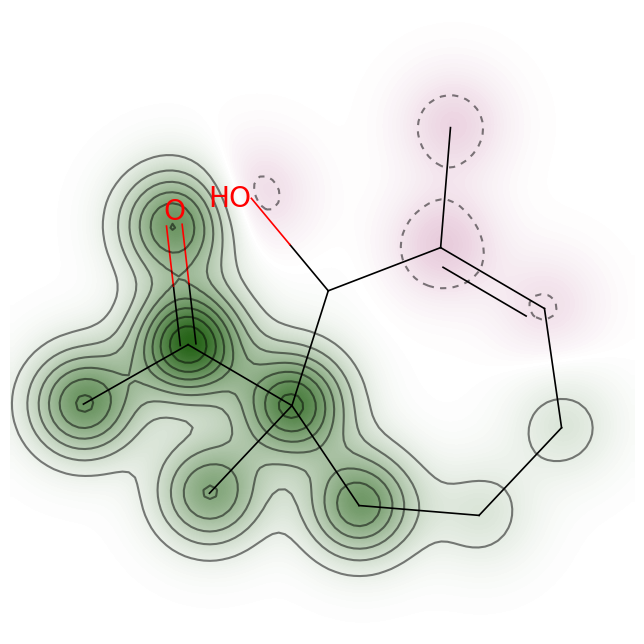

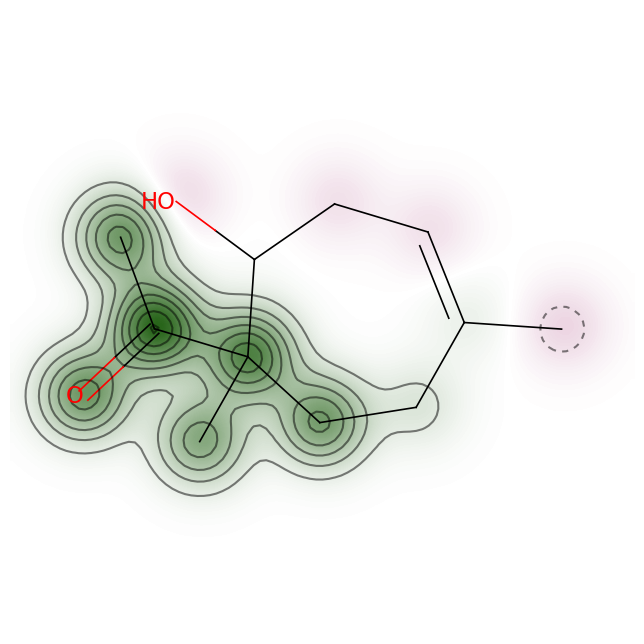

In [16]:
# generate similarity maps of most suitable candidates 

smiles=similarity_df["morgan"].to_list()

# get most similar molecule from dataframe, convert SMILES to molecule
smiles_top_result = str(similarity_df['Smiles'].values[0])
mol_top_result = Chem.MolFromSmiles(smiles_top_result)

# generate similarity map
fp = SimilarityMaps.GetMorganFingerprint(mol_top_result, fpType='bv')
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(similarity_target, mol_top_result, SimilarityMaps.GetMorganFingerprint)

# TODO: get first n most similar molecules from dataframe (list), generate n similarity maps - need a function. All we need out of the dataframe is the SMILES string - extract as list?  
top10 = similarity_df.head(10)
smileslist = top10['Smiles'].tolist()
print(smileslist)

for smiles in smileslist: 
    mol_object_for_map = Chem.MolFromSmiles(smiles)
    fp = SimilarityMaps.GetMorganFingerprint(mol_object_for_map, fpType='bv')
    fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(similarity_target, mol_object_for_map, SimilarityMaps.GetMorganFingerprint)